In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from Common import NeuralNet
import time

torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

In [2]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_, t0_=0, tf_=8, lambda_u_=10, coefficient_neurons_=20, coefficient_layers_=4, alpha_f_=0.005, h_f_=5, T_hot_=4, T_0_=1, U_f_=None):
        self.n_int = n_int_     # n_int_:= number of intertior points
        self.n_sb = n_sb_       # n_sb_ := number of spatial boundary points
        self.n_tb = n_tb_       # n_tb_ := number of time boundary points

        # Set the paremeters of the equation
        self.alpha_f = alpha_f_
        self.h_f = h_f_
        self.T_hot = T_hot_
        self.T_0 = T_0_
        self.U_f = U_f_

        # Extrema of the solution domain (t,x) in [0, t]x[0, L]
        self.domain_extrema = torch.tensor([[t0_, tf_],  # Time dimension
                                            [0, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = lambda_u_

        # Number of neurons in the coefficient NN
        self.coefficient_neurons =coefficient_neurons_
        self.coefficient_layers = coefficient_layers_

        # FF Dense NN to approximate the solution of the underlying reaction-convection-diffusion equations of the fluid
        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=1, # is a NN with input_dim=2 (time & space), output_dim=1 (fluid_temp)
                                              n_hidden_layers=4,
                                              neurons=20,
                                              regularization_param=0.,
                                              regularization_exp=2.,
                                              retrain_seed=42)
        
        # FF Dense NN to approximate the solid temperature we wish to infer
        self.approximate_coefficient = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=1,  # is a NN with input_dim=2 (time & space), output_dim=1 (solid_temp)
                                                 n_hidden_layers=coefficient_layers_,
                                                 neurons=coefficient_neurons_,
                                                 regularization_param=0.,
                                                 regularization_exp=2.,
                                                 retrain_seed=42)

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])   # it will create a 2 cloumns tensor, the rows nunmber is specified after every time it is used

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int, self.training_set_meas = self.assemble_datasets()

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]
    
    # Function Uf(t) -> given the time it gives back the velocity of the fluid in the relative phase
    def fluid_velocity(self, inputs):
        Uf = torch.full(inputs.shape, 999)  # give all 999 for semplicity when testing

        # Charging Phase
        if (self.domain_extrema[0, 1] <= 1) or (self.domain_extrema[0, 0] >= 4 and self.domain_extrema[0, 1] <=5 ): Uf = torch.full(inputs.shape, 1)
        
        # Discharging Phase
        elif (self.domain_extrema[0, 0] >= 2 and self.domain_extrema[0, 1] <= 3) or (self.domain_extrema[0, 0] >= 6 and self.domain_extrema[0, 1] <= 7): Uf = torch.full(inputs.shape, -1)

        # Idle Phase
        elif (self.domain_extrema[0, 0] >= 1 and self.domain_extrema[0, 1] <= 2) or (self.domain_extrema[0, 0] >= 3 and self.domain_extrema[0, 1] <= 4) or (self.domain_extrema[0, 0] >= 5 and self.domain_extrema[0, 1] <= 6) or (self.domain_extrema[0, 0] >= 7 and self.domain_extrema[0, 1] <= 8): Uf = torch.full(inputs.shape, 0)

        return Uf
    
    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))    # input_sb has two columns (t, x) both with random numbers in the two respective domains
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)   # overwrite the entier column of time with t0
        output_tb = torch.full(input_tb[:, 0].shape, self.T_0).reshape(-1, 1)   # the output has 1 column

        return input_tb, output_tb  # input_tb is the sequence of x_n; output_tb is the sequence u0(x_n)

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        # Dataset with random [t, x] in the domain
        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        # Assigne the spatial boundary x=x0
        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        # Assigne the spatial boundary x=xL
        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        # Require the gradient
        input_sb_0.requires_grad = True
        input_sb_L.requires_grad = True

        # Compute the output for the the different phases

        # Charging Phase
        if (self.domain_extrema[0, 1] <= 1) or (self.domain_extrema[0, 0] >= 4 and self.domain_extrema[0, 1] <=5 ):
            output_sb_0 = torch.full(input_sb_0[:, 0].shape, self.T_hot).reshape(-1, 1)
            output_sb_L = torch.full(input_sb_L[:, 0].shape, 0).reshape(-1, 1)
        
        # Discharging Phase
        elif (self.domain_extrema[0, 0] >= 2 and self.domain_extrema[0, 1] <= 3) or (self.domain_extrema[0, 0] >= 6 and self.domain_extrema[0, 1] <= 7):
            output_sb_0 = torch.full(input_sb_0[:, 0].shape, 0).reshape(-1, 1)
            output_sb_L = torch.full(input_sb_L[:, 0].shape, self.T_0).reshape(-1, 1)

        # Idle Phase
        elif (self.domain_extrema[0, 0] >= 1 and self.domain_extrema[0, 1] <= 2) or (self.domain_extrema[0, 0] >= 3 and self.domain_extrema[0, 1] <= 4) or (self.domain_extrema[0, 0] >= 5 and self.domain_extrema[0, 1] <= 6) or (self.domain_extrema[0, 0] >= 7 and self.domain_extrema[0, 1] <= 8):
            output_sb_0 = torch.full(input_sb_0[:, 0].shape, 0).reshape(-1, 1)
            output_sb_L = torch.full(input_sb_L[:, 0].shape, 0).reshape(-1, 1)               

        return torch.cat([input_sb_0, input_sb_L], dim=0), torch.cat([output_sb_0, output_sb_L], dim=0)


    # Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        # Now we use the convert fct since we want the t is in [0, 8]
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        
        return input_int, output_int
    
    # Function returning the input-output tensor required to assemble the training set S_meas corresponding to the measured points in the domain.
    # These points are read from the file "DataSolution.txt"
    def get_measurement_data(self):
        # Read the CSV file into a DataFrame
        df_meas = pd.read_csv('DataSolution.txt')

        # From the data consider only the one in the specific phase the domain is in
        # Charge Phase 1
        if (self.domain_extrema[0, 1] <= 1):
            df_meas = df_meas[(df_meas['t']<=1)]
        
        # Charge Phase 2
        elif (self.domain_extrema[0, 0] >= 4 and self.domain_extrema[0, 1] <=5 ):
            df_meas = df_meas[(df_meas['t']>=4) & (df_meas['t']<=5)]
        
        # Discharge Phase 1
        elif (self.domain_extrema[0, 0] >= 2 and self.domain_extrema[0, 1] <= 3):
            df_meas = df_meas[(df_meas['t']>=2) & (df_meas['t']<=3)]
        
        # Discharge Phase 2
        elif (self.domain_extrema[0, 0] >= 6 and self.domain_extrema[0, 1] <= 7):
            df_meas = df_meas[(df_meas['t']>=6) & (df_meas['t']<=7)]
        
        # Idle Phase 1
        elif (self.domain_extrema[0, 0] >= 1 and self.domain_extrema[0, 1] <= 2):
            df_meas = df_meas[(df_meas['t']>=1) & (df_meas['t']<=2)]
        
        # Idle Phase 2
        elif (self.domain_extrema[0, 0] >= 3 and self.domain_extrema[0, 1] <= 4):
            df_meas = df_meas[(df_meas['t']>=3) & (df_meas['t']<=4)]

        # Idle Phase 3
        elif (self.domain_extrema[0, 0] >= 5 and self.domain_extrema[0, 1] <= 6):
            df_meas = df_meas[(df_meas['t']>=5) & (df_meas['t']<=6)]
        
        # Idle Phase 4
        elif (self.domain_extrema[0, 0] >= 7 and self.domain_extrema[0, 1] <= 8):
            df_meas = df_meas[(df_meas['t']>=7) & (df_meas['t']<=8)]

        # Convert the DataFrame to a torch.tensor
        tensor_meas = torch.tensor(df_meas.values , dtype=torch.float)
        
        # The first 2 columns are the inputs: [t, x]
        input_meas = tensor_meas[:, :2]
        
        # The last column are the outputs: [Tf]
        output_meas = tensor_meas[:, 2:]
        return input_meas, output_meas

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()    # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()   # S_tb
        input_int, output_int = self.add_interior_points()          # S_int
        input_meas, output_meas = self.get_measurement_data()       # S_meas

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2*self.space_dimensions*self.n_sb, shuffle=False)  #batch_size has *8 since there are 8 different phases and for each one we have 2 conditions (x0 & xL)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)
        training_set_meas = DataLoader(torch.utils.data.TensorDataset(input_meas, output_meas), batch_size=output_meas.shape[0], shuffle=False)

        return training_set_sb, training_set_tb, training_set_int, training_set_meas

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)
        
        return u_pred_tb

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_sb):
        assert (input_sb.requires_grad==True)   # make sure the grad is requested so we can compute the derivatives

        # Split the input into the 2 boundaries
        input_sb_0 = input_sb[:int(input_sb.shape[0]/2), :]
        input_sb_L = input_sb[int(input_sb.shape[0]/2):, :]
        
        # Charge Phase
        if (self.domain_extrema[0, 1] <= 1) or (self.domain_extrema[0, 0] >= 4 and self.domain_extrema[0, 1] <=5 ):
            # x0
            u_pred_sb_0 = self.approximate_solution(input_sb_0)

            # xL
            u_pred_Tf = self.approximate_solution(input_sb_L)
            u_pred_sb_L = torch.autograd.grad(u_pred_Tf.sum(), input_sb_L, create_graph=True)[0][:, 1].reshape(-1, 1) # take only d/dx
        
        # Discharge Phase
        elif (self.domain_extrema[0, 0] >= 2 and self.domain_extrema[0, 1] <= 3) or (self.domain_extrema[0, 0] >= 6 and self.domain_extrema[0, 1] <= 7):
            # x0
            u_pred_Tf = self.approximate_solution(input_sb_0)
            u_pred_sb_0 = torch.autograd.grad(u_pred_Tf.sum(), input_sb_0, create_graph=True)[0][:, 1].reshape(-1, 1) # take only d/dx

            # xL
            u_pred_sb_L = self.approximate_solution(input_sb_L)
        
        # Idle Phase
        elif (self.domain_extrema[0, 0] >= 1 and self.domain_extrema[0, 1] <= 2) or (self.domain_extrema[0, 0] >= 3 and self.domain_extrema[0, 1] <= 4) or (self.domain_extrema[0, 0] >= 5 and self.domain_extrema[0, 1] <= 6) or (self.domain_extrema[0, 0] >= 7 and self.domain_extrema[0, 1] <= 8):
            # x0
            u_pred_Tf = self.approximate_solution(input_sb_0)
            u_pred_sb_0 = torch.autograd.grad(u_pred_Tf.sum(), input_sb_0, create_graph=True)[0][:, 1].reshape(-1, 1) # take only d/dx

            # xL
            u_pred_Tf = self.approximate_solution(input_sb_L)
            u_pred_sb_L = torch.autograd.grad(u_pred_Tf.sum(), input_sb_L, create_graph=True)[0][:, 1].reshape(-1, 1) # take only d/dx
        
        return torch.cat([u_pred_sb_0, u_pred_sb_L], dim=0)

    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True
        u = self.approximate_solution(input_int).reshape(-1,)       # u is the solution (Tf) of the PDE
        g = self.approximate_coefficient(input_int).reshape(-1,)    # g is the function (Ts) that is requested

        # grad compute the gradient of a "SCALAR" function L with respect to some input nxm TENSOR Z=[[x1, y1],[x2,y2],[x3,y3],...,[xn,yn]], m=2
        # it returns grad_L = [[dL/dx1, dL/dy1],[dL/dx2, dL/dy2],[dL/dx3, dL/dy3],...,[dL/dxn, dL/dyn]]
        # Note: pytorch considers a tensor [u1, u2,u3, ... ,un] a vectorial function
        # whereas sum_u = u1 + u2 + u3 + u4 + ... + un as a "scalar" one

        # In our case ui = u(xi), therefore the line below returns:
        # grad_u = [[dsum_u/dx1, dsum_u/dy1],[dsum_u/dx2, dsum_u/dy2],[dsum_u/dx3, dL/dy3],...,[dsum_u/dxm, dsum_u/dyn]]
        # and dsum_u/dxi = d(u1 + u2 + u3 + u4 + ... + un)/dxi = d(u(x1) + u(x2) u3(x3) + u4(x4) + ... + u(xn))/dxi = dui/dxi

        # Since u for us is u = (uf, us), we have to devide the two cases

        grad_u = torch.autograd.grad(u.sum(), input_int, create_graph=True)[0]
        grad_u_t = grad_u[:, 0]
        grad_u_x = grad_u[:, 1]
        grad_u_xx = torch.autograd.grad(grad_u_x.sum(), input_int, create_graph=True)[0][:, 1]

        # Compute the velocity of the fluid Uf(t)
        Uf = self.fluid_velocity(input_int[:, 0])

        residual = (grad_u_t + Uf*grad_u_x) - (self.alpha_f*grad_u_xx - self.h_f*(u-g))

        return residual.reshape(-1, )

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, inp_train_meas, u_train_meas, verbose=True):
        u_pred_sb = self.apply_boundary_conditions(inp_train_sb)
        u_pred_tb = self.apply_initial_condition(inp_train_tb)
        u_pred_meas = self.approximate_solution(inp_train_meas)

        assert (u_pred_sb.shape[1] == u_train_sb.shape[1])
        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])
        assert (u_pred_meas.shape[1] == u_train_meas.shape[1])

        r_int = self.compute_pde_residual(inp_train_int)
        r_sb = u_train_sb - u_pred_sb
        r_tb = u_train_tb - u_pred_tb
        r_meas = u_train_meas - u_pred_meas

        loss_sb = torch.mean(abs(r_sb) ** 2)
        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_int = torch.mean(abs(r_int) ** 2)
        loss_meas = torch.mean(abs(r_meas) ** 2)

        loss_u = loss_sb + loss_tb + loss_meas

        loss = torch.log10(self.lambda_u * loss_u + loss_int)
        # loss = torch.log10(self.lambda_u * loss_u + loss_int)

        if verbose: print("Total loss: ", round(loss.item(), 4), "| Boundary Loss: ", round(torch.log10(loss_int).item(), 4), "| Measure Loss: ", round(torch.log10(loss_meas).item(), 4), "| Function Loss: ", round(torch.log10(loss_u).item(), 4))

        # Save the losses in some attributes
        self.total_loss = round(loss.item(), 4)
        self.boundary_loss = round(torch.log10(loss_int).item(), 4)
        self.measure_loss = round(torch.log10(loss_meas).item(), 4)
        self.function_loss = round(torch.log10(loss_u).item(), 4)

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        # Start the timer
        start_time = time.time()

        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int), (inp_train_meas, u_train_meas)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int, self.training_set_meas)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, inp_train_meas, u_train_meas, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss
                
                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])
        print("Run time for the fitting: ", round((time.time()- start_time)/60), " minutes", round((time.time()- start_time)%60), " seconds")

        # Save the run time in an attribute
        self.run_time = (time.time()- start_time)
        return history

    ################################################################################################
    def plotting(self, vmax_=None):
        inputs = self.soboleng.draw(100000)
        inputs = self.convert(inputs)

        output_tf = self.approximate_solution(inputs).reshape(-1, )
        output_ts = self.approximate_coefficient(inputs).reshape(-1, )

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        if vmax_ is None: im1 = axs[0].scatter(inputs[:, 0].detach(), inputs[:, 1].detach(), c=output_tf.detach(), cmap="jet")
        else: im1 = axs[0].scatter(inputs[:, 0].detach(), inputs[:, 1].detach(), c=output_tf.detach(), cmap="jet", vmax=vmax_)
        axs[0].set_xlabel("t")
        axs[0].set_ylabel("x")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        if vmax_ is None: im2 = axs[1].scatter(inputs[:, 0].detach(), inputs[:, 1].detach(), c=output_ts.detach(), cmap="jet")
        else: im2 = axs[1].scatter(inputs[:, 0].detach(), inputs[:, 1].detach(), c=output_ts.detach(), cmap="jet", vmax=vmax_)
        axs[1].set_xlabel("t")
        axs[1].set_ylabel("x")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title(r"Approximate Solution $T_f$")
        axs[1].set_title(r"Approximate Solution $T_s$")

        plt.show()

In [3]:
n_int = 256
n_sb = 64
n_tb = 64

t_0 = 7
t_f = 8

pinn = Pinns(n_int, n_sb, n_tb, t0_=t_0, tf_=t_f)

### Train

In [4]:
n_epochs = 1
optimizer_LBFGS = optim.LBFGS(list(pinn.approximate_solution.parameters()) + list(pinn.approximate_coefficient.parameters()),
                              lr=float(0.5),
                              max_iter=50000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)

################################  0  ################################
Total loss:  1.3878 | Boundary Loss:  -3.4031 | Measure Loss:  0.1869 | Function Loss:  0.3878
Total loss:  1.2812 | Boundary Loss:  -0.2312 | Measure Loss:  0.0873 | Function Loss:  0.2677
Total loss:  1.0557 | Boundary Loss:  0.6921 | Measure Loss:  -0.2645 | Function Loss:  -0.1907
Total loss:  0.9507 | Boundary Loss:  0.6177 | Measure Loss:  -0.3571 | Function Loss:  -0.3205
Total loss:  0.6991 | Boundary Loss:  -0.1554 | Measure Loss:  -0.4928 | Function Loss:  -0.3663
Total loss:  0.633 | Boundary Loss:  -0.1239 | Measure Loss:  -0.5155 | Function Loss:  -0.4506
Total loss:  0.528 | Boundary Loss:  -0.9039 | Measure Loss:  -0.5118 | Function Loss:  -0.4884
Total loss:  0.509 | Boundary Loss:  -2.2513 | Measure Loss:  -0.5115 | Function Loss:  -0.4918
Total loss:  0.5083 | Boundary Loss:  -2.2562 | Measure Loss:  -0.5109 | Function Loss:  -0.4924
Total loss:  0.5072 | Boundary Loss:  -2.1247 | Measure Loss:  -0.

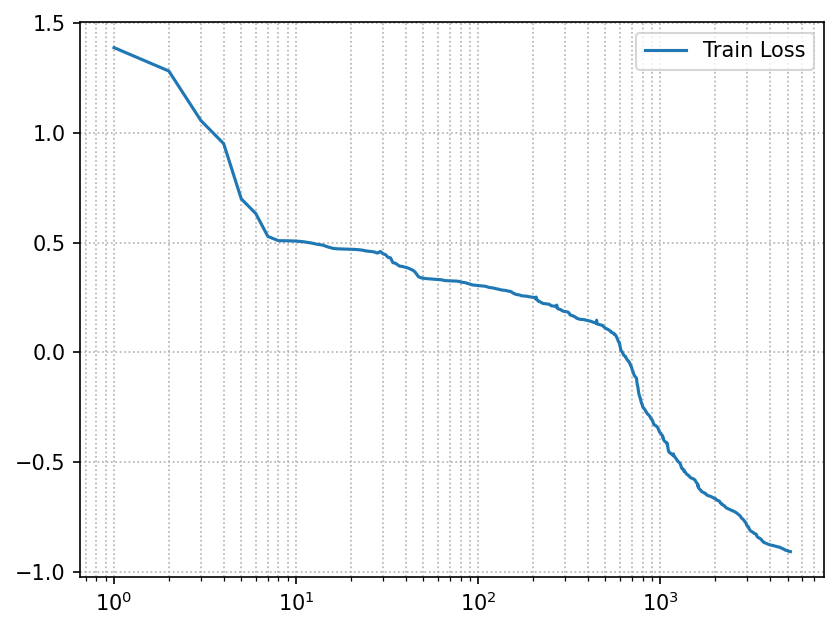

In [5]:
hist = pinn.fit(num_epochs=n_epochs,
                optimizer=optimizer_LBFGS,
                verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

#### Save the parameters

In [6]:
torch.save(pinn.approximate_solution.state_dict(), 'phase8_approximate_solution_parameters.pth')
torch.save(pinn.approximate_coefficient.state_dict(), 'phase8_approximate_coefficient_parameters.pth')

### Load the pre-trained pinn

In [11]:
# pinn.approximate_solution.load_state_dict(torch.load("test1_approximate_solution_parameters.pth"))
# pinn.approximate_coefficient.load_state_dict(torch.load("test1_approximate_solution_parameters.pth"))

<All keys matched successfully>

### Plot the solution

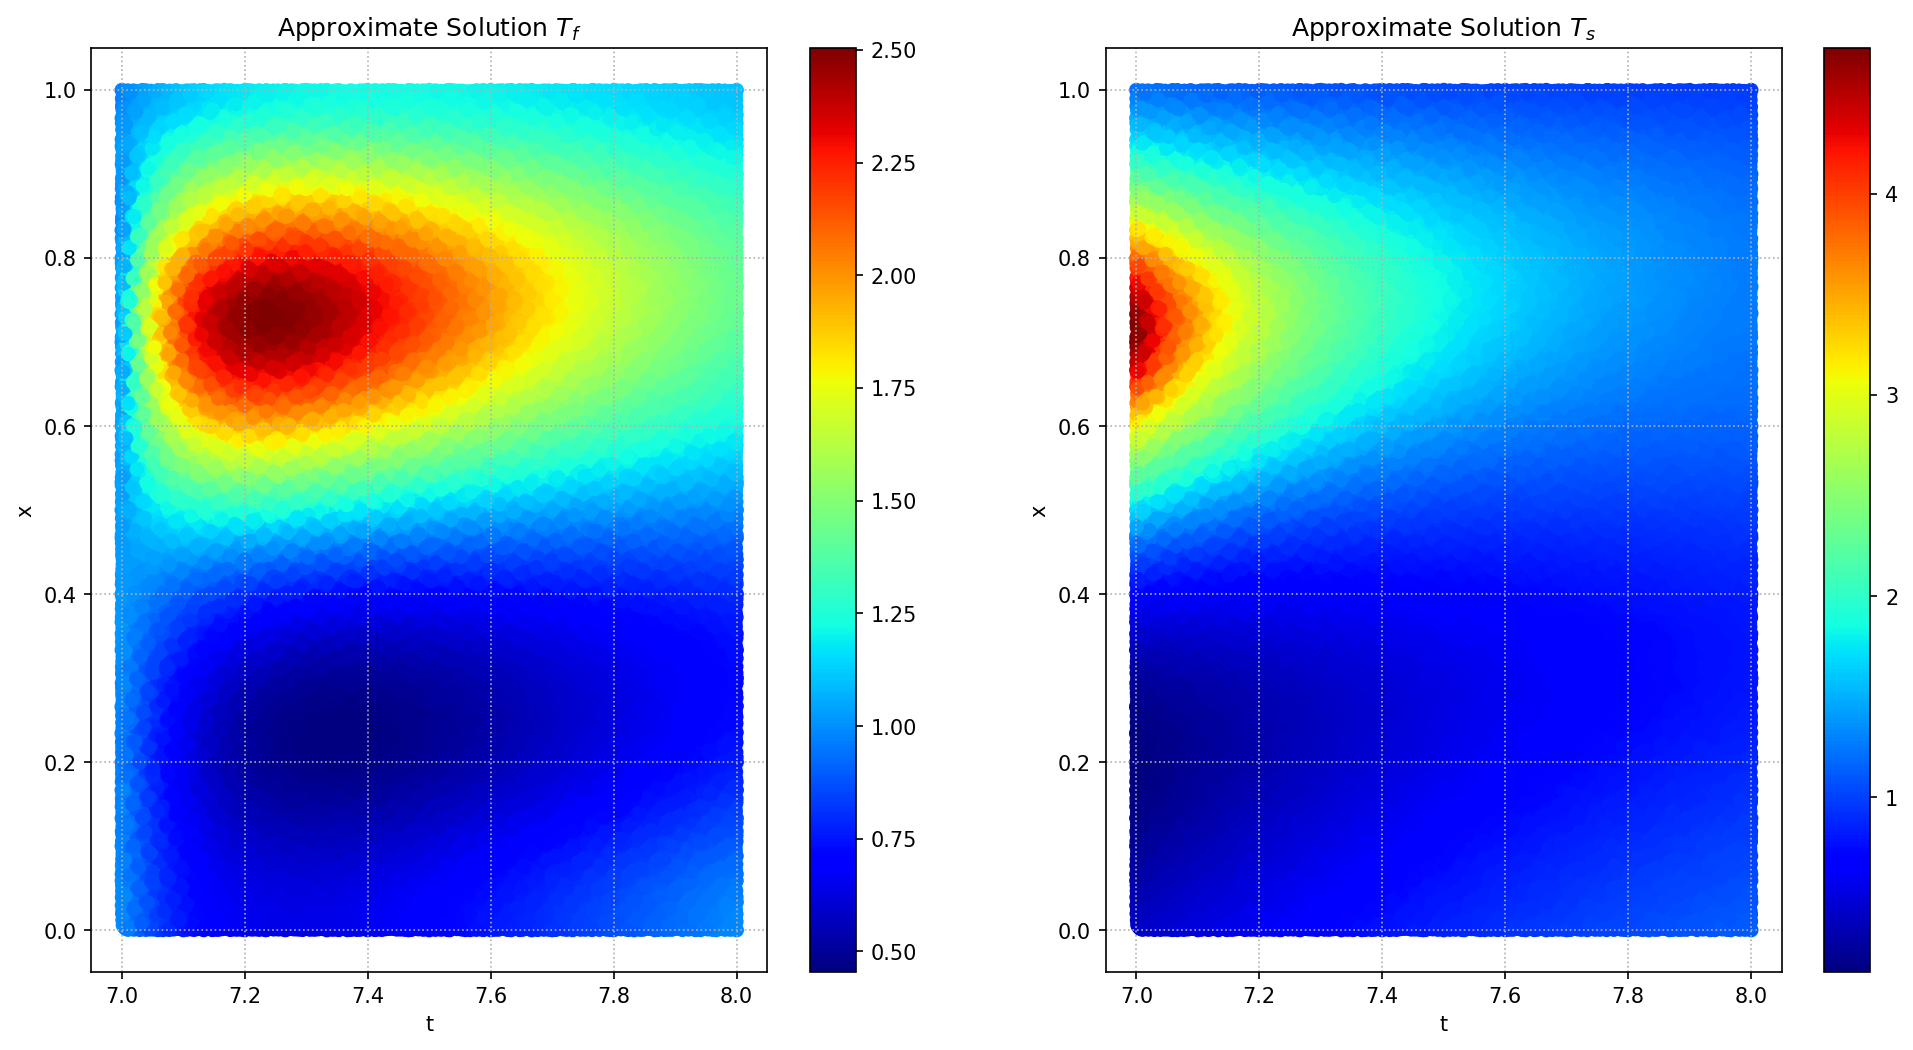

In [7]:
pinn.plotting()

### Temporal Boundary Conditions

The initial conditions for the fluid temperature are:

$$
T_f(x, t=0) = T_0 \quad \forall x \in [0, 1]
$$

Where for us: $\quad T_0 = 1$

In [8]:
# Create the input points where to evaluate the predioctions
input_test_tb = pinn.soboleng.draw(10)
input_test_tb[:, 0] = torch.full(input_test_tb[:, 0].shape, 0)    # assigne t=0 to all points

Tf = pinn.approximate_solution(input_test_tb)
exact_solution = torch.full(Tf.shape, pinn.T_0)

print('------------------------------------------------------------')
print('Parametes of the error for the Temporal Boundary Conditions')
print('------------------------------------------------------------')
print('mean of the relative error:\t', torch.mean(torch.abs((exact_solution-Tf))/torch.abs(exact_solution)*100).item(), '%' )
print('mean error:\t\t\t', torch.mean(torch.abs( (exact_solution-Tf)) ).item())
print('std error:\t\t\t', torch.std( (exact_solution-Tf) ).item())

------------------------------------------------------------
Parametes of the error for the Temporal Boundary Conditions
------------------------------------------------------------
mean of the relative error:	 0.15455245971679688 %
mean error:			 0.0015455245738849044
std error:			 0.0015252471202984452


### Spatial Boundary Conditions

#### Charing Phase

The boundary conditions for the Charing Phase are:

$$
T_f(x=0, t)=T_{hot}, \qquad \frac{\partial{T_f(x,t)}}{\partial{x}}\Bigr|_{x=1} = 0, \quad \forall t \in [0,1]\vee[4,5]
$$

Where for us: $\quad T_{hot}=4$

In [9]:
x0 = pinn.domain_extrema[1, 0]
xL = pinn.domain_extrema[1, 1]

# Create the input points where to evaluate the predioctions
input_test_sb_charing = pinn.soboleng.draw(10)
delta_time = torch.zeros_like(input_test_sb_charing)

# Exact solution
exact_solution_x0 = torch.full(delta_time[:,0].shape, pinn.T_hot)
exact_solution_xL = torch.full(delta_time[:,0].shape, 0)

"""Cycle 1"""
delta_time[:, 0] = torch.full(delta_time[:, 0].shape, 0)

input_test_sb_charing_x0_1 = torch.clone(input_test_sb_charing)
input_test_sb_charing_x0_1[:, 1] = torch.full(input_test_sb_charing[:, 1].shape, x0)    # assigne x=x0 to all points
input_test_sb_charing_x0_1 = input_test_sb_charing_x0_1 + delta_time    # add the delta_time

input_test_sb_charing_xL_1 = torch.clone(input_test_sb_charing)
input_test_sb_charing_xL_1[:, 1] = torch.full(input_test_sb_charing[:, 1].shape, xL)    # assigne x=x0 to all points
input_test_sb_charing_xL_1 = input_test_sb_charing_xL_1 + delta_time    # add the delta_time

# Make predictions
Tf_x0_1 = pinn.approximate_solution(input_test_sb_charing_x0_1)

input_test_sb_charing_xL_1.requires_grad = True
Tf_xL_1 = pinn.approximate_solution(input_test_sb_charing_xL_1)
dTf_xL_1 = torch.autograd.grad(Tf_xL_1.sum(), input_test_sb_charing_xL_1)[0][:, 1] # take dx

# Compute the relative error
rel_err_x0_1 = torch.mean(torch.abs((exact_solution_x0-Tf_x0_1))/torch.abs(exact_solution_x0)*100)
rel_err_xL_1 = torch.mean(torch.abs((exact_solution_xL-dTf_xL_1))/torch.abs(exact_solution_xL)*100)

"""Cycle 2"""
delta_time[:, 0] = torch.full(delta_time[:, 0].shape, 4)

input_test_sb_charing_x0_2 = torch.clone(input_test_sb_charing)
input_test_sb_charing_x0_2[:, 1] = torch.full(input_test_sb_charing[:, 1].shape, x0)    # assigne x=x0 to all points
input_test_sb_charing_x0_2 = input_test_sb_charing_x0_2 + delta_time    # add the delta_time

input_test_sb_charing_xL_2 = torch.clone(input_test_sb_charing)
input_test_sb_charing_xL_2[:, 1] = torch.full(input_test_sb_charing[:, 1].shape, xL)    # assigne x=x0 to all points
input_test_sb_charing_xL_2 = input_test_sb_charing_xL_2 + delta_time    # add the delta_time

# Make predictions
Tf_x0_2 = pinn.approximate_solution(input_test_sb_charing_x0_2)

input_test_sb_charing_xL_2.requires_grad = True
Tf_xL_2 = pinn.approximate_solution(input_test_sb_charing_xL_2)
dTf_xL_2 = torch.autograd.grad(Tf_xL_2.sum(), input_test_sb_charing_xL_2)[0][:, 1] # take dx

# Compute the relative error
rel_err_x0_2 = torch.mean(torch.abs((exact_solution_x0-Tf_x0_2))/torch.abs(exact_solution_x0)*100)
rel_err_xL_2 = torch.mean(torch.abs((exact_solution_xL-dTf_xL_2))/torch.abs(exact_solution_xL)*100)

print('---------------------------------------------------------------------------------')
print('Parametes of the error for the Spatial Boundary Conditions -> Charging Phase')
print('---------------------------------------------------------------------------------')
print('Cycle 1\t\t\t\t|\tx=x0\t\t|\tx=xL\t\t|')
print('mean of the relative error:\t|\t', round(rel_err_x0_1.item(), 4) , '%\t|\t', round(rel_err_xL_1.item(), 4) , '%\t|' )
print()
print('Cycle 2\t\t\t\t|\tx=x0\t\t|\tx=xL\t\t|')
print('mean of the relative error:\t|\t', round(rel_err_x0_2.item(), 4) , '%\t|\t', round(rel_err_xL_2.item(), 4) , '%\t|' )

---------------------------------------------------------------------------------
Parametes of the error for the Spatial Boundary Conditions -> Charging Phase
---------------------------------------------------------------------------------
Cycle 1				|	x=x0		|	x=xL		|
mean of the relative error:	|	 0.5783 %	|	 inf %	|

Cycle 2				|	x=x0		|	x=xL		|
mean of the relative error:	|	 0.508 %	|	 inf %	|


#### Discharging Phase

The boundary conditions for the Discharging Phase are:

$$
\frac{\partial{T_f(x,t)}}{\partial{x}}\Bigr|_{x=0} = 0, \qquad T_f(x=1, t)=T_{0}, \quad \forall t \in [2,3]\vee[6,7]
$$

Where for us: $\quad T_{0}=0$

In [10]:
x0 = pinn.domain_extrema[1, 0]
xL = pinn.domain_extrema[1, 1]

# Create the input points where to evaluate the predioctions
input_test_sb_discharging = pinn.soboleng.draw(10)
delta_time = torch.zeros_like(input_test_sb_discharging)

# Exact solution
exact_solution_x0 = torch.full(delta_time[:,0].shape, 0)
exact_solution_xL = torch.full(delta_time[:,0].shape, pinn.T_0)

"""Cycle 1"""
delta_time[:, 0] = torch.full(delta_time[:, 0].shape, 2)

input_test_sb_discharging_x0_1 = torch.clone(input_test_sb_discharging)
input_test_sb_discharging_x0_1[:, 1] = torch.full(input_test_sb_discharging[:, 1].shape, x0)    # assigne x=x0 to all points
input_test_sb_discharging_x0_1 = input_test_sb_discharging_x0_1 + delta_time    # add the delta_time

input_test_sb_discharging_xL_1 = torch.clone(input_test_sb_discharging)
input_test_sb_discharging_xL_1[:, 1] = torch.full(input_test_sb_discharging[:, 1].shape, xL)    # assigne x=x0 to all points
input_test_sb_discharging_xL_1 = input_test_sb_discharging_xL_1 + delta_time    # add the delta_time

# Make predictions

input_test_sb_discharging_x0_1.requires_grad = True
Tf_x0_1 = pinn.approximate_solution(input_test_sb_discharging_x0_1)
dTf_x0_1 = torch.autograd.grad(Tf_x0_1.sum(), input_test_sb_discharging_x0_1)[0][:, 1] # take dx

Tf_xL_1 = pinn.approximate_solution(input_test_sb_discharging_xL_1)

# Compute the relative error
rel_err_x0_1 = torch.mean(torch.abs((exact_solution_x0-dTf_x0_1))/torch.abs(exact_solution_x0)*100)
rel_err_xL_1 = torch.mean(torch.abs((exact_solution_xL-Tf_xL_1))/torch.abs(exact_solution_xL)*100)

"""Cycle 2"""
delta_time[:, 0] = torch.full(delta_time[:, 0].shape, 6)

input_test_sb_discharging_x0_2 = torch.clone(input_test_sb_discharging)
input_test_sb_discharging_x0_2[:, 1] = torch.full(input_test_sb_discharging[:, 1].shape, x0)    # assigne x=x0 to all points
input_test_sb_discharging_x0_2 = input_test_sb_discharging_x0_2 + delta_time    # add the delta_time

input_test_sb_discharging_xL_2 = torch.clone(input_test_sb_discharging)
input_test_sb_discharging_xL_2[:, 1] = torch.full(input_test_sb_discharging[:, 1].shape, xL)    # assigne x=x0 to all points
input_test_sb_discharging_xL_2 = input_test_sb_discharging_xL_2 + delta_time    # add the delta_time

# Make predictions
input_test_sb_discharging_x0_2.requires_grad = True
Tf_x0_2 = pinn.approximate_solution(input_test_sb_discharging_x0_2)
dTf_x0_2 = torch.autograd.grad(Tf_x0_2.sum(), input_test_sb_discharging_x0_2)[0][:, 1] # take dx


Tf_xL_2 = pinn.approximate_solution(input_test_sb_discharging_xL_2)

# Compute the relative error
rel_err_x0_2 = torch.mean(torch.abs((exact_solution_x0-dTf_x0_2))/torch.abs(exact_solution_x0)*100)
rel_err_xL_2 = torch.mean(torch.abs((exact_solution_xL-Tf_xL_2))/torch.abs(exact_solution_xL)*100)

print('---------------------------------------------------------------------------------')
print('Parametes of the error for the Spatial Boundary Conditions -> Discharging Phase')
print('---------------------------------------------------------------------------------')
print('Cycle 1\t\t\t\t|\tx=x0\t\t|\tx=xL\t\t|')
print('mean of the relative error:\t|\t', round(rel_err_x0_1.item(), 4) , '%\t|\t', round(rel_err_xL_1.item(), 4) , '%\t|' )
print()
print('Cycle 2\t\t\t\t|\tx=x0\t\t|\tx=xL\t\t|')
print('mean of the relative error:\t|\t', round(rel_err_x0_2.item(), 4) , '%\t|\t', round(rel_err_xL_2.item(), 4) , '%\t|' )

---------------------------------------------------------------------------------
Parametes of the error for the Spatial Boundary Conditions -> Discharging Phase
---------------------------------------------------------------------------------
Cycle 1				|	x=x0		|	x=xL		|
mean of the relative error:	|	 inf %	|	 0.8565 %	|

Cycle 2				|	x=x0		|	x=xL		|
mean of the relative error:	|	 inf %	|	 1.362 %	|


#### Idle Phase

The boundary conditions for the Idle Phase are:

$$
\frac{\partial{T_f(x,t)}}{\partial{x}}\Bigr|_{x=0} = 0, \qquad \frac{\partial{T_f(x,t)}}{\partial{x}}\Bigr|_{x=1} = 0, \quad \forall t \in [1,2]\vee[3,4]\vee[5,6]\vee[7,8]
$$

In [11]:
x0 = pinn.domain_extrema[1, 0]
xL = pinn.domain_extrema[1, 1]

# Create the input points where to evaluate the predioctions
input_test_sb_idle = pinn.soboleng.draw(10)
delta_time = torch.zeros_like(input_test_sb_idle)

# Exact solution
exact_solution_x0 = torch.full(delta_time[:,0].shape, 0)
exact_solution_xL = torch.full(delta_time[:,0].shape, 0)

"""Cycle 1"""
delta_time[:, 0] = torch.full(delta_time[:, 0].shape, 1)

input_test_sb_idle_x0_1 = torch.clone(input_test_sb_idle)
input_test_sb_idle_x0_1[:, 1] = torch.full(input_test_sb_idle[:, 1].shape, x0)    # assigne x=x0 to all points
input_test_sb_idle_x0_1 = input_test_sb_idle_x0_1 + delta_time    # add the delta_time

input_test_sb_idle_xL_1 = torch.clone(input_test_sb_idle)
input_test_sb_idle_xL_1[:, 1] = torch.full(input_test_sb_idle[:, 1].shape, xL)    # assigne x=x0 to all points
input_test_sb_idle_xL_1 = input_test_sb_idle_xL_1 + delta_time    # add the delta_time

# Make predictions

input_test_sb_idle_x0_1.requires_grad = True
Tf_x0_1 = pinn.approximate_solution(input_test_sb_idle_x0_1)
dTf_x0_1 = torch.autograd.grad(Tf_x0_1.sum(), input_test_sb_idle_x0_1)[0][:, 1] # take dx

input_test_sb_idle_xL_1.requires_grad = True
Tf_xL_1 = pinn.approximate_solution(input_test_sb_idle_xL_1)
dTf_xL_1 = torch.autograd.grad(Tf_xL_1.sum(), input_test_sb_idle_xL_1)[0][:, 1] # take dx

# Compute the relative error
rel_err_x0_1 = torch.mean(torch.abs((exact_solution_x0-dTf_x0_1))/torch.abs(exact_solution_x0)*100)
rel_err_xL_1 = torch.mean(torch.abs((exact_solution_xL-dTf_xL_1))/torch.abs(exact_solution_xL)*100)

"""Cycle 2"""
delta_time[:, 0] = torch.full(delta_time[:, 0].shape, 3)

input_test_sb_idle_x0_2 = torch.clone(input_test_sb_idle)
input_test_sb_idle_x0_2[:, 1] = torch.full(input_test_sb_idle[:, 1].shape, x0)    # assigne x=x0 to all points
input_test_sb_idle_x0_2 = input_test_sb_idle_x0_2 + delta_time    # add the delta_time

input_test_sb_idle_xL_2 = torch.clone(input_test_sb_idle)
input_test_sb_idle_xL_2[:, 1] = torch.full(input_test_sb_idle[:, 1].shape, xL)    # assigne x=x0 to all points
input_test_sb_idle_xL_2 = input_test_sb_idle_xL_2 + delta_time    # add the delta_time

# Make predictions
input_test_sb_idle_x0_2.requires_grad = True
Tf_x0_2 = pinn.approximate_solution(input_test_sb_idle_x0_2)
dTf_x0_2 = torch.autograd.grad(Tf_x0_2.sum(), input_test_sb_idle_x0_2)[0][:, 1] # take dx

input_test_sb_idle_xL_2.requires_grad = True
Tf_xL_2 = pinn.approximate_solution(input_test_sb_idle_xL_2)
dTf_xL_2 = torch.autograd.grad(Tf_xL_2.sum(), input_test_sb_idle_xL_2)[0][:, 1] # take dx

# Compute the relative error
rel_err_x0_2 = torch.mean(torch.abs((exact_solution_x0-dTf_x0_2))/torch.abs(exact_solution_x0)*100)
rel_err_xL_2 = torch.mean(torch.abs((exact_solution_xL-dTf_xL_2))/torch.abs(exact_solution_xL)*100)

"""Cycle 3"""
delta_time[:, 0] = torch.full(delta_time[:, 0].shape, 5)

input_test_sb_idle_x0_3 = torch.clone(input_test_sb_idle)
input_test_sb_idle_x0_3[:, 1] = torch.full(input_test_sb_idle[:, 1].shape, x0)    # assigne x=x0 to all points
input_test_sb_idle_x0_3 = input_test_sb_idle_x0_3 + delta_time    # add the delta_time

input_test_sb_idle_xL_3 = torch.clone(input_test_sb_idle)
input_test_sb_idle_xL_3[:, 1] = torch.full(input_test_sb_idle[:, 1].shape, xL)    # assigne x=x0 to all points
input_test_sb_idle_xL_3 = input_test_sb_idle_xL_3 + delta_time    # add the delta_time

# Make predictions
input_test_sb_idle_x0_3.requires_grad = True
Tf_x0_3 = pinn.approximate_solution(input_test_sb_idle_x0_3)
dTf_x0_3 = torch.autograd.grad(Tf_x0_3.sum(), input_test_sb_idle_x0_3)[0][:, 1] # take dx

input_test_sb_idle_xL_3.requires_grad = True
Tf_xL_3 = pinn.approximate_solution(input_test_sb_idle_xL_3)
dTf_xL_3 = torch.autograd.grad(Tf_xL_3.sum(), input_test_sb_idle_xL_3)[0][:, 1] # take dx

# Compute the relative error
rel_err_x0_3 = torch.mean(torch.abs((exact_solution_x0-dTf_x0_3))/torch.abs(exact_solution_x0)*100)
rel_err_xL_3 = torch.mean(torch.abs((exact_solution_xL-dTf_xL_3))/torch.abs(exact_solution_xL)*100)

"""Cycle 4"""
delta_time[:, 0] = torch.full(delta_time[:, 0].shape, 7)

input_test_sb_idle_x0_4 = torch.clone(input_test_sb_idle)
input_test_sb_idle_x0_4[:, 1] = torch.full(input_test_sb_idle[:, 1].shape, x0)    # assigne x=x0 to all points
input_test_sb_idle_x0_4 = input_test_sb_idle_x0_4 + delta_time    # add the delta_time

input_test_sb_idle_xL_4 = torch.clone(input_test_sb_idle)
input_test_sb_idle_xL_4[:, 1] = torch.full(input_test_sb_idle[:, 1].shape, xL)    # assigne x=x0 to all points
input_test_sb_idle_xL_4 = input_test_sb_idle_xL_4 + delta_time    # add the delta_time

# Make predictions
input_test_sb_idle_x0_4.requires_grad = True
Tf_x0_4 = pinn.approximate_solution(input_test_sb_idle_x0_4)
dTf_x0_4 = torch.autograd.grad(Tf_x0_4.sum(), input_test_sb_idle_x0_4)[0][:, 1] # take dx

input_test_sb_idle_xL_4.requires_grad = True
Tf_xL_4 = pinn.approximate_solution(input_test_sb_idle_xL_4)
dTf_xL_4 = torch.autograd.grad(Tf_xL_4.sum(), input_test_sb_idle_xL_4)[0][:, 1] # take dx

# Compute the relative error
rel_err_x0_4 = torch.mean(torch.abs((exact_solution_x0-dTf_x0_4))/torch.abs(exact_solution_x0)*100)
rel_err_xL_4 = torch.mean(torch.abs((exact_solution_xL-dTf_xL_4))/torch.abs(exact_solution_xL)*100)

print('---------------------------------------------------------------------------------')
print('Parametes of the error for the Spatial Boundary Conditions -> Idle Phase')
print('---------------------------------------------------------------------------------')
print('Cycle 1\t\t\t\t|\tx=x0\t\t|\tx=xL\t\t|')
print('mean of the relative error:\t|\t', round(rel_err_x0_1.item(), 4) , '%\t|\t', round(rel_err_xL_1.item(), 4) , '%\t|' )
print()
print('Cycle 2\t\t\t\t|\tx=x0\t\t|\tx=xL\t\t|')
print('mean of the relative error:\t|\t', round(rel_err_x0_2.item(), 4) , '%\t|\t', round(rel_err_xL_2.item(), 4) , '%\t|' )
print()
print('Cycle 3\t\t\t\t|\tx=x0\t\t|\tx=xL\t\t|')
print('mean of the relative error:\t|\t', round(rel_err_x0_3.item(), 4) , '%\t|\t', round(rel_err_xL_3.item(), 4) , '%\t|' )
print()
print('Cycle 3\t\t\t\t|\tx=x0\t\t|\tx=xL\t\t|')
print('mean of the relative error:\t|\t', round(rel_err_x0_4.item(), 4) , '%\t|\t', round(rel_err_xL_4.item(), 4) , '%\t|' )

---------------------------------------------------------------------------------
Parametes of the error for the Spatial Boundary Conditions -> Idle Phase
---------------------------------------------------------------------------------
Cycle 1				|	x=x0		|	x=xL		|
mean of the relative error:	|	 inf %	|	 inf %	|

Cycle 2				|	x=x0		|	x=xL		|
mean of the relative error:	|	 inf %	|	 inf %	|

Cycle 3				|	x=x0		|	x=xL		|
mean of the relative error:	|	 inf %	|	 inf %	|

Cycle 3				|	x=x0		|	x=xL		|
mean of the relative error:	|	 inf %	|	 inf %	|


### Measured data

In [26]:
err = (torch.mean((exact_meas - prediction_meas) ** 2) / torch.mean(exact_meas ** 2)) ** 0.5 * 100
print("L2 Relative Error Norm: ", err.item(), "%")

L2 Relative Error Norm:  64.61476135253906 %


----------------------------------------------------
Parametes of the error for the Measured Data
----------------------------------------------------
mean of the relative error:	 63.39130783081055 %
mean error:			 0.7190259695053101
std error:			 0.9493223428726196


Text(0.5, 1.0, 'Approximate Values $T_s$')

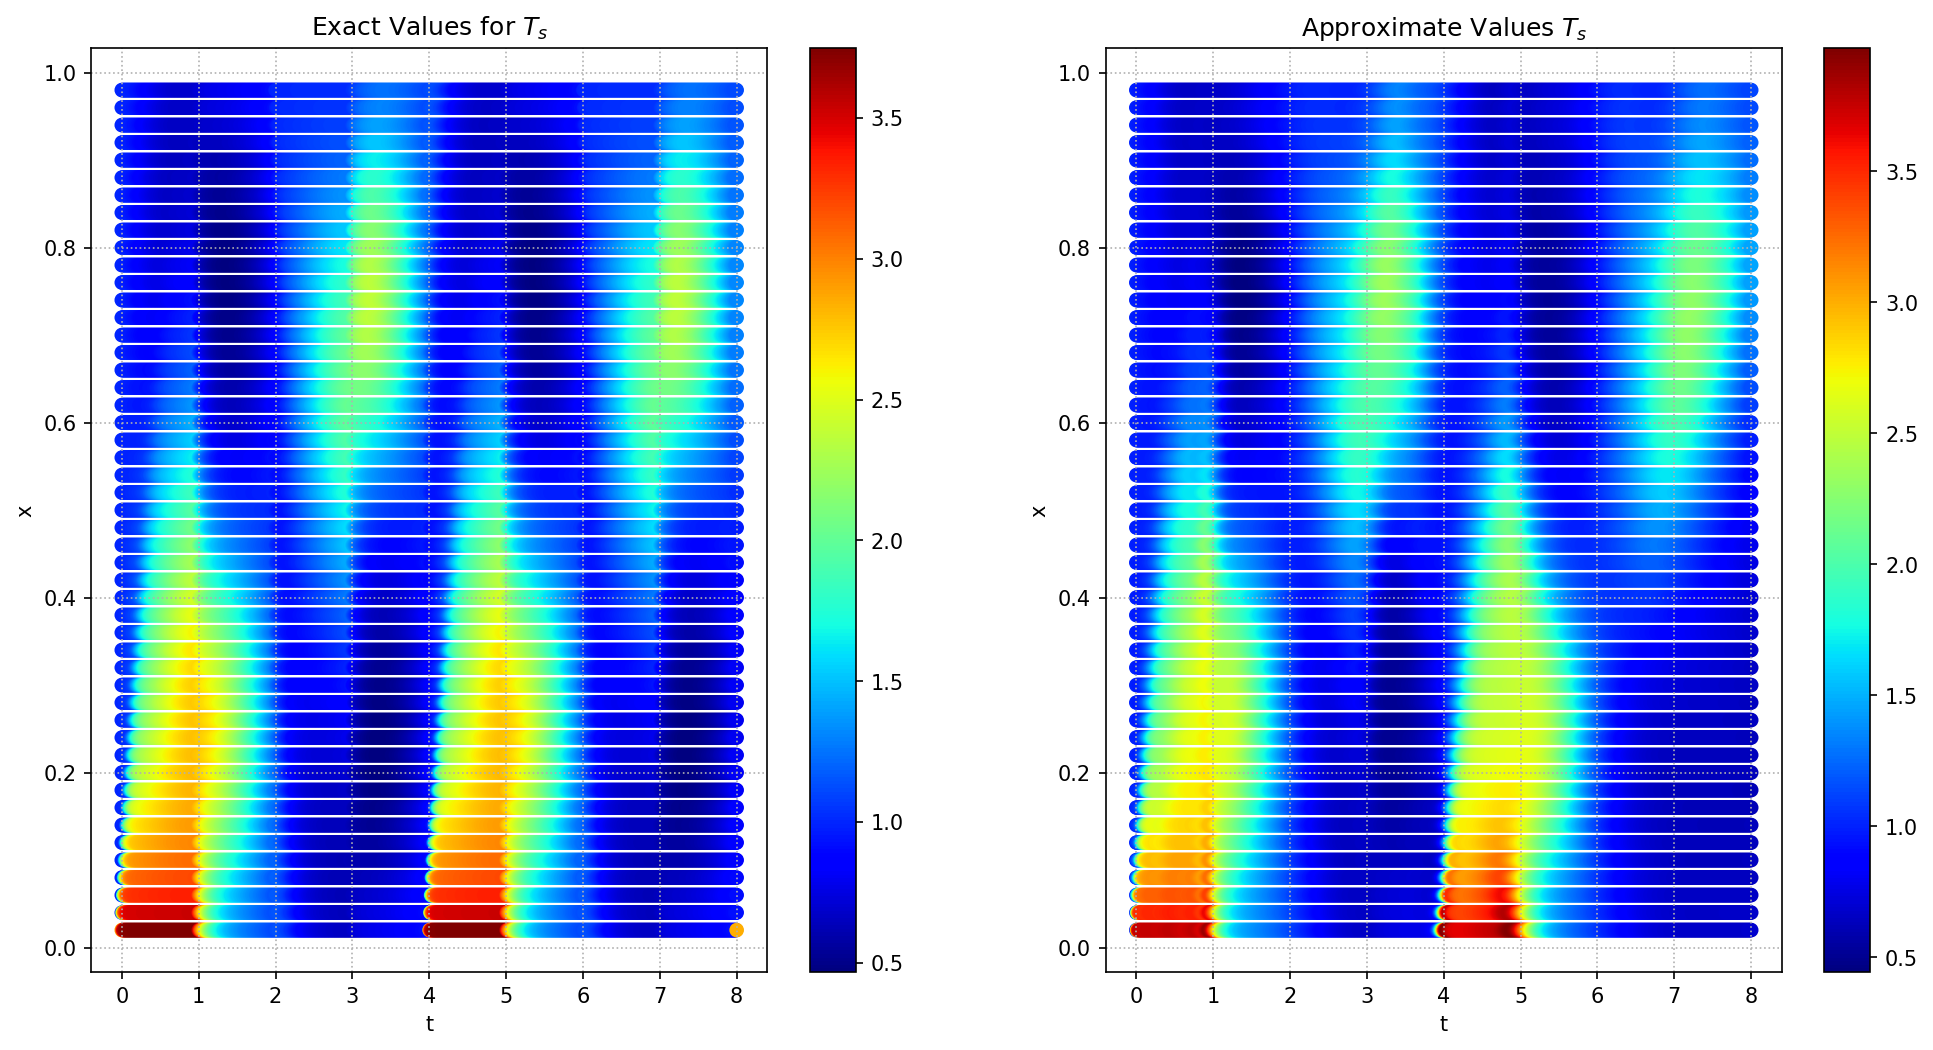

In [29]:
input_meas, exact_meas = pinn.get_measurement_data()

prediction_meas = pinn.approximate_solution(input_meas).reshape(-1, )

print('----------------------------------------------------')
print('Parametes of the error for the Measured Data')
print('----------------------------------------------------')
print('mean of the relative error:\t', torch.mean(torch.abs((exact_meas-prediction_meas))/torch.abs(exact_meas)*100).item(), '%' )
print('mean error:\t\t\t', torch.mean(torch.abs( (exact_meas-prediction_meas)) ).item())
print('std error:\t\t\t', torch.std( (exact_meas-prediction_meas) ).item())

# Plot the predictions vs the exact solutions
fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
im1 = axs[0].scatter(input_meas[:, 0].detach(), input_meas[:, 1].detach(), c=exact_meas.detach(), cmap='jet')
axs[0].set_xlabel("t")
axs[0].set_ylabel("x")
plt.colorbar(im1, ax=axs[0])
axs[0].grid(True, which="both", ls=":")
im2 = axs[1].scatter(input_meas[:, 0].detach(), input_meas[:, 1].detach(), c=prediction_meas.detach(), cmap="jet")
axs[1].set_xlabel("t")
axs[1].set_ylabel("x")
plt.colorbar(im2, ax=axs[1])
axs[1].grid(True, which="both", ls=":")
axs[0].set_title(r"Exact Values for $T_s$")
axs[1].set_title(r"Approximate Values $T_s$")

### Fluid velocity

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


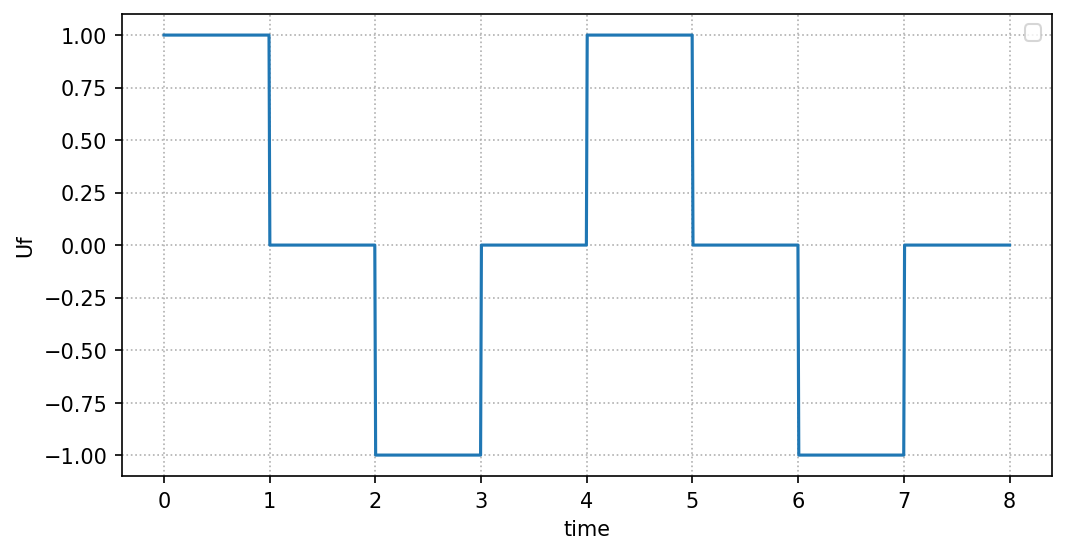

In [11]:
# Generate some points for the time in [0, 8]
input_time = torch.linspace(0, 8, 1000, dtype=torch.float).reshape(-1, 1)

Uf = pinn.fluid_velocity(input_time)

plt.figure(figsize=(8, 4), dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(input_time.detach().numpy(), Uf.detach().numpy())
plt.xlabel("time")
plt.ylabel("Uf")
plt.legend()
plt.show()